In [1]:
# Cell 1: Imports & path setup
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ensure we can import download_stock_data
sys.path.append(os.path.abspath(os.path.join("..", "src")))

from data.download_data import download_stock_data

In [2]:
# Cell 2: Choose a ticker and date range
ticker = "JOBY"
start_date = "2024-01-01"
end_date   = "2024-06-30"

# Download (or read from CSV if already saved)
df = download_stock_data(ticker, start_date, end_date, save_csv=True)

# If CSV exists already, you can also load directly:
# df = pd.read_csv(f"data/raw/{ticker}.csv", parse_dates=["Date"])

# Quick check
df.head()

📥 Downloading JOBY from Polygon.io...
[✓] Data saved to /Users/tony/AlphaVestra/data/raw/JOBY.csv


,Date,Open,High,Low,Close,Volume
0,2024-01-02 05:00:00,6.62,6.620,6.12,6.18,7377726.0
1,2024-01-03 05:00:00,6.10,6.110,5.94,5.98,5570468.0
2,2024-01-04 05:00:00,6.00,6.225,5.94,6.05,4209967.0
3,2024-01-05 05:00:00,6.00,6.190,5.97,6.09,3071212.0
4,2024-01-08 05:00:00,6.16,6.420,6.09,6.37,3759619.0


In [3]:
# Cell 3: Calculate short and long moving averages
# Typical choice: short = 20-day MA, long = 50-day MA
df["MA_short"] = df["Close"].rolling(window=20).mean()
df["MA_long"]  = df["Close"].rolling(window=50).mean()

# Drop rows where MAs aren’t yet defined
df.dropna(subset=["MA_short", "MA_long"], inplace=True)

# Preview
df[["Date", "Close", "MA_short", "MA_long"]].head()

,Date,Close,MA_short,MA_long
49,2024-03-13 04:00:00,5.35,5.6245,5.7710
50,2024-03-14 04:00:00,5.11,5.5680,5.7496
51,2024-03-15 04:00:00,5.08,5.5035,5.7316
52,2024-03-18 04:00:00,5.12,5.4495,5.7130
53,2024-03-19 04:00:00,5.03,5.3905,5.6918


In [4]:
# Cell 4: Create columns for signals
# When MA_short crosses above MA_long → buy (1)
# When MA_short crosses below MA_long → sell (-1)
# Otherwise → 0 (hold)

# Detect when short MA crosses above long MA → “buy”
cross_up = (
    (df["MA_short"] > df["MA_long"]) &
    (df["MA_short"].shift(1) <= df["MA_long"].shift(1))
)

# Detect when short MA crosses below long MA → “sell”
cross_down = (
    (df["MA_short"] < df["MA_long"]) &
    (df["MA_short"].shift(1) >= df["MA_long"].shift(1))
)

# Initialize position column
df["position"] = 0
df.loc[cross_up,   "position"] = 1   # buy signal
df.loc[cross_down, "position"] = -1  # sell signal

# Preview the first few signals
df.loc[cross_up | cross_down, ["Date", "Close", "MA_short", "MA_long", "position"]].head()

# Identify buy/sell events
buys  = df[df["position"] == 1]
sells = df[df["position"] == -1]


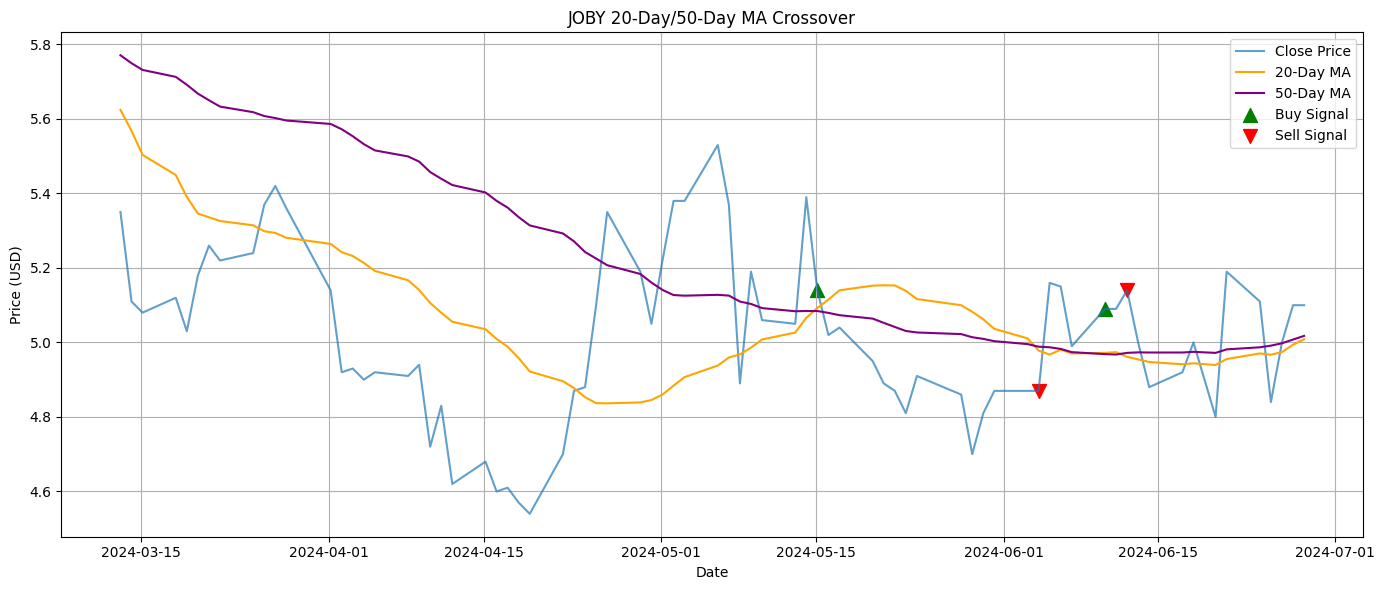

In [5]:
# Cell 5: Plot Close price, MAs, and markers for buy/sell
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["Close"],  label="Close Price", alpha=0.7)
plt.plot(df["Date"], df["MA_short"], label="20-Day MA", color="orange")
plt.plot(df["Date"], df["MA_long"],  label="50-Day MA", color="purple")

# Mark buy points
plt.scatter(buys["Date"], buys["Close"], marker="^", color="green", s=100, label="Buy Signal")
# Mark sell points
plt.scatter(sells["Date"], sells["Close"], marker="v", color="red",   s=100, label="Sell Signal")

plt.title(f"{ticker} 20-Day/50-Day MA Crossover")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Cell 6: Simple backtest—track returns if we buy at next open after signal

# Double-check the DataFrame is sorted by date, ensure chronological ordering and reset index
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# Create a column for strategy returns
df["returns"] = df["Close"].pct_change()  # daily market return
df["strategy_returns"] = 0.0

# Simulate being “in position” between buy (1) and sell (–1) signals
in_position = False
for i in range(1, len(df)):
    prev_pos = df.loc[i-1, "position"]
    if prev_pos == 1:       # we got a buy signal yesterday
        in_position = True
    elif prev_pos == -1:    # we got a sell signal yesterday
        in_position = False

    if in_position:
        # Earn the market return if we’re long
        df.loc[i, "strategy_returns"] = df.loc[i, "returns"]


# Compute cumulative returns
df["cum_market"]   = (1 + df["returns"]).cumprod() - 1
df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod() - 1

# Display the last few rows
df[["Date", "Close", "position", "returns", "strategy_returns", "cum_market", "cum_strategy"]].tail()

,Date,Close,position,returns,strategy_returns,cum_market,cum_strategy
70,2024-06-24 04:00:00,5.11,0,-0.015414,0.0,-0.044860,-0.043222
71,2024-06-25 04:00:00,4.84,0,-0.052838,0.0,-0.095327,-0.043222
72,2024-06-26 04:00:00,5.00,0,0.033058,0.0,-0.065421,-0.043222
73,2024-06-27 04:00:00,5.10,0,0.020000,0.0,-0.046729,-0.043222
74,2024-06-28 04:00:00,5.10,0,0.000000,0.0,-0.046729,-0.043222


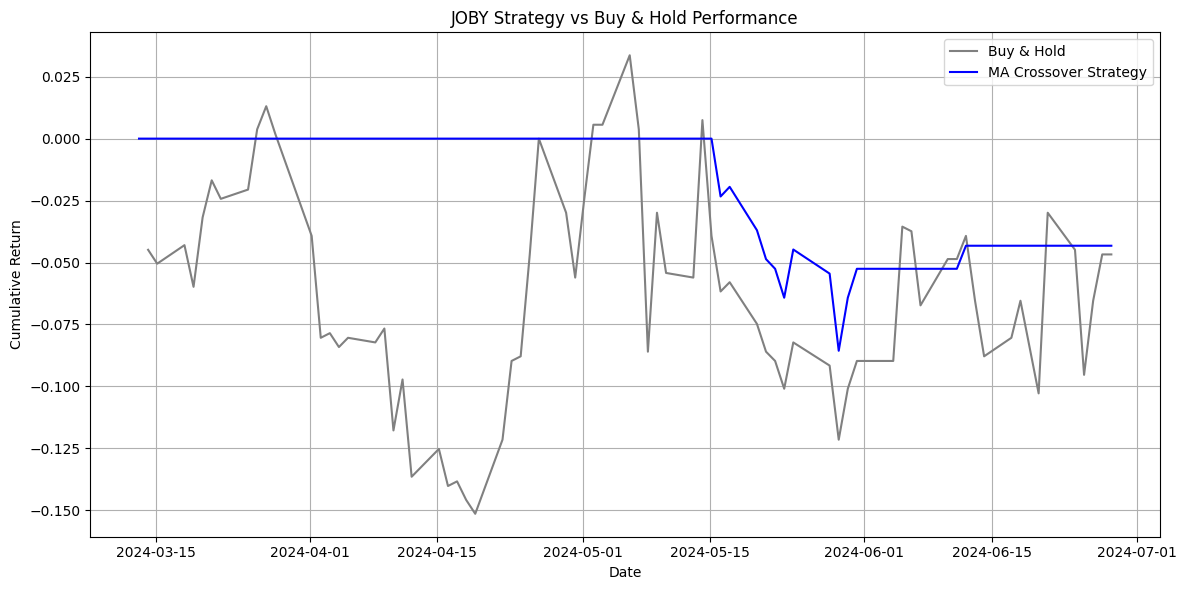

In [7]:
# Cell 7: Plot cumulative returns for both
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["cum_market"],   label="Buy & Hold", color="gray")
plt.plot(df["Date"], df["cum_strategy"], label="MA Crossover Strategy", color="blue")
plt.title(f"{ticker} Strategy vs Buy & Hold Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()